In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os, glob, random, itertools
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [3]:

# ---------------------------------------------------------
# 1. Paths & constants
# ---------------------------------------------------------
DATASET_DIR = "/content/drive/MyDrive/ChestXRay2017/chest_xray"   # <-- change if needed
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
AUTOTUNE    = tf.data.AUTOTUNE

# ---------------------------------------------------------
# 2. Build a DataFrame of filepaths + clean labels
# ---------------------------------------------------------
def subclass_from_filename(fname: str) -> str:
    """Return 'bacterial', 'viral', or generic 'pneumonia'."""
    lower = fname.lower()
    if "_bacteria" in lower: return "bacterial"
    if "_virus"    in lower: return "viral"
    return "pneumonia"                 # fallback

records = []
for split in ("train", "test"):
    for cls in ("NORMAL", "PNEUMONIA"):
        folder = os.path.join(DATASET_DIR, split, cls)
        for fp in glob.glob(os.path.join(folder, "*.jpeg")):
            label = "normal" if cls == "NORMAL" else subclass_from_filename(fp)
            records.append((fp, label, split))

df = pd.DataFrame(records, columns=["filepath", "label", "split"])
print("Total images:", len(df))
df.head()


Total images: 5876


,filepath,label,split
0,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
1,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
2,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
3,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train
4,/content/drive/MyDrive/ChestXRay2017/chest_xra...,normal,train


In [4]:
# ---------------------------------------------------------
# 3. Create a validation split
# ---------------------------------------------------------
from sklearn.model_selection import train_test_split

train_df = df[df.split=="train"]
train_idx, val_idx = train_test_split(
    train_df.index,
    test_size=0.15,
    stratify=train_df["label"],
    random_state=42)

df.loc[val_idx, "split"] = "val"
print(df["split"].value_counts())


split
train    4464
val       788
test      624
Name: count, dtype: int64


# **Exploratory Data Analysis**

## **Class distribution by split**

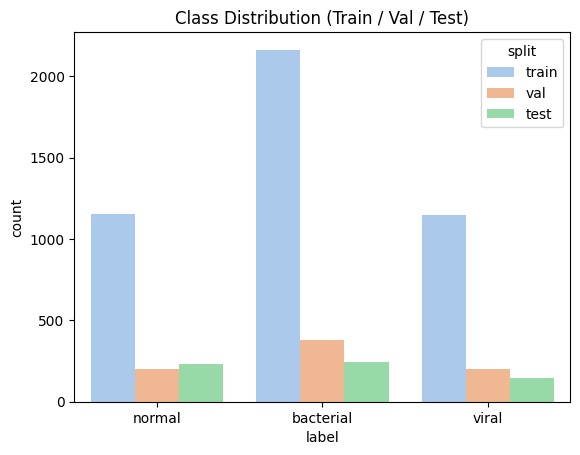

In [6]:
#   Class distribution by split
sns.countplot(x="label", hue="split", data=df, palette="pastel")
plt.title("Class Distribution (Train / Val / Test)")
plt.show()

## **Random image mosaics for sanity-check**

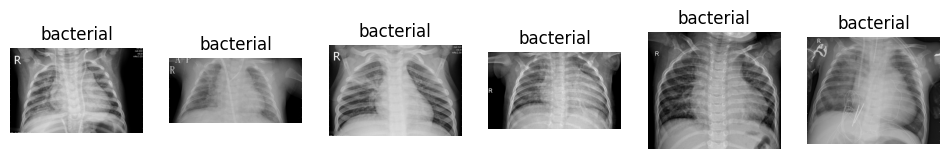

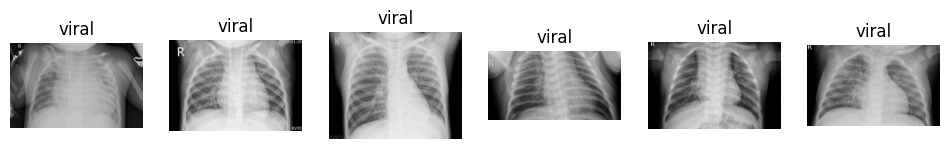

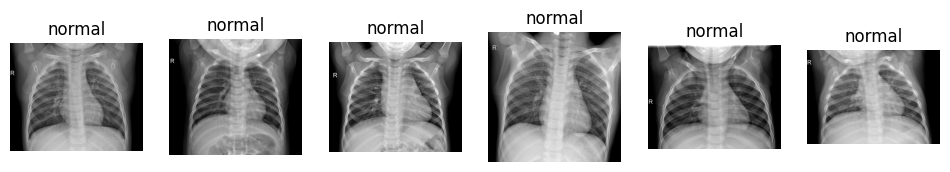

In [7]:
# Random image mosaics for sanity-check
def show_random_samples(lbl="bacterial", n=6):
    sample_paths = df[(df.label==lbl) & (df.split=="train")]["filepath"].sample(n)
    plt.figure(figsize=(12,2))
    for i, fp in enumerate(sample_paths, 1):
        img = plt.imread(fp)
        plt.subplot(1, n, i)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(lbl)
    plt.show()

for lbl in ["bacterial", "viral", "normal"]:
    show_random_samples(lbl)

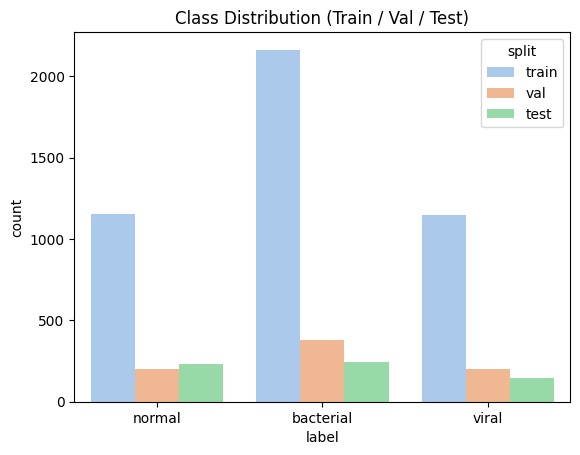

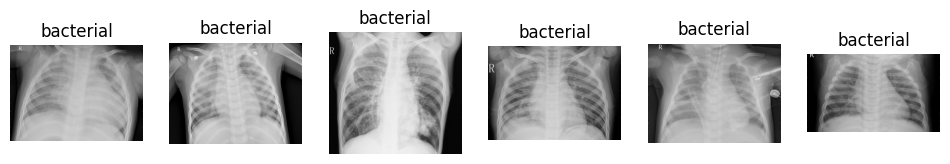

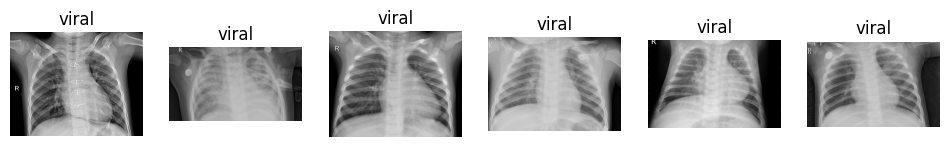

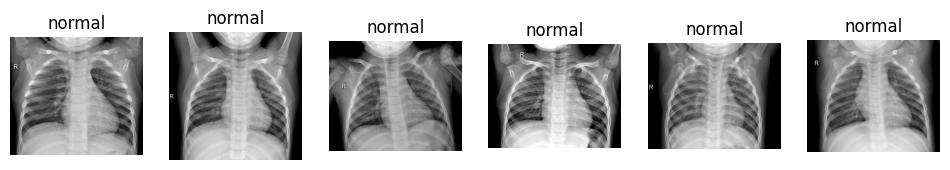

  0%|          | 0/5876 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [5]:


#  Image-size statistics
shapes = [tf.image.decode_jpeg(tf.io.read_file(fp), channels=3).shape
          for fp in tqdm(df["filepath"])]
shape_df = pd.DataFrame(shapes, columns=["h","w","c"])
print(shape_df.describe()[["h","w"]])


# **Preprocessing**

In [8]:

# helper: list of filepaths & labels → tf.data.Dataset
label_to_index = {lbl:i for i,lbl in enumerate(sorted(df["label"].unique()))}

def paths_to_dataset(filepaths, labels):
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    # -- map strings → image tensors + one-hot labels
    def _load(path, lbl):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32) / 255.0         # [0,1]
        lbl = tf.one_hot(lbl, depth=len(label_to_index))
        return img, lbl
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    return ds

# Gather splits
train_paths = df[df.split=="train"]["filepath"].tolist()
train_labels= df[df.split=="train"]["label"].map(label_to_index).tolist()

val_paths   = df[df.split=="val"]["filepath"].tolist()
val_labels  = df[df.split=="val"]["label"].map(label_to_index).tolist()

test_paths  = df[df.split=="test"]["filepath"].tolist()
test_labels = df[df.split=="test"]["label"].map(label_to_index).tolist()

# Build datasets
train_ds = paths_to_dataset(train_paths, train_labels)\
             .shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds   = paths_to_dataset(val_paths, val_labels)\
             .batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds  = paths_to_dataset(test_paths, test_labels)\
             .batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Dataset shapes →", next(iter(train_ds))[0].shape, next(iter(train_ds))[1].shape)


Dataset shapes → (32, 224, 224, 3) (32, 3)
